In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from IPython import display
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disables INFO & WARNING logs
from losses import total_loss
from maptd_model import maptd_model
from pipeline_v2 import get_dataset, get_dataset_from_txt_files

from tkinter.filedialog import askdirectory

In [ ]:
img_dir = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD/data/general_dataset/images'
json_dir = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD/data/general_dataset/json'

In [ ]:
dataset_dir = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/general_dataset/'
INITIAL_DIR = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/ckpts/models'

conf_file_dir = askdirectory(initialdir=INITIAL_DIR, title='Select the directory '
    'with the configuration files')
print(conf_file_dir)

In [ ]:
def show_score_map(tile, gt_score_map, pred_score_map, threshold=None):
    pred_score_map = np.where(pred_score_map > threshold, 1, 0)
    COLORMAP = 'gray'
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(np.squeeze(tf.cast(tile, tf.uint8)))
    ax[1].imshow(np.squeeze(gt_score_map), cmap=COLORMAP)
    ax[2].imshow(np.squeeze(pred_score_map), cmap=COLORMAP)
    plt.show()

## Training

In [ ]:
@tf.function()
def train_step(model, optimizer, tile, 
               score_map, geo_map, training_mask, 
               step, summary_writer):
    
    with tf.GradientTape() as tape:
        pred_score_map, pred_geo_map = model(tile, training=True)

        loss = total_loss(score_map, pred_score_map, geo_map, pred_geo_map, 
                          training_mask)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    with summary_writer.as_default():
        tf.summary.scalar('total_loss', loss, step=step//1000)
        
    return pred_score_map

In [ ]:
TILE_SIZE = 512
BATCH_SIZE = 16
maptd = maptd_model(input_size=TILE_SIZE)

log_dir = os.path.join(conf_file_dir, 'logs')
sum_writer = tf.summary.create_file_writer(os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

ckpt_dir = os.path.join(conf_file_dir, 'training_ckpts')
ckpt_prefix = os.path.join(ckpt_dir, 'ckpt')
ckpt = tf.train.Checkpoint(model=maptd)

In [ ]:
train_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'train', batch_size=BATCH_SIZE)
test_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'test', batch_size=1)

In [8]:
def fit(model, train_dataset, test_dataset, summary_writer,
        total_steps=2**20, step_to_reduce_lr=2**17):
    initial_lr = 1e-4
    opt = tf.keras.optimizers.Adam(learning_rate=initial_lr, epsilon=1e-8)
    start = time.time()
    
    for step, (tile, score_map, geo_map, training_mask) in \
                train_dataset.repeat().take(total_steps).enumerate():
        
        pred_score_map = train_step(model, opt, tile, 
                                    score_map, geo_map, training_mask,
                                    step, summary_writer)
        
        if step.numpy() % 10 == 0:
            display.clear_output(wait=True)
            print(f'Step {step.numpy()}/{total_steps}')
            if step.numpy() != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            example_tile, example_score_map, _, _ = next(iter(test_ds.take(1)))
            example_pred_score_map, _ = maptd(example_tile, training=True)
            show_score_map(example_tile, 
                           example_score_map, 
                           example_pred_score_map, 
                           threshold=0.7)            
            
            start = time.time()
            
            
        if step.numpy() == step_to_reduce_lr:
            new_lr = 1e-5
            opt = tf.keras.optimizers.Adam(learning_rate=new_lr, epsilon=1e-8)
            print(f'The learning rate for the optimizer was decreased from '
                  f'{initial_lr} to {new_lr}')
            
        
        if (step.numpy() + 1) % 50 == 0:
            ckpt.save(file_prefix=ckpt_prefix)

Step 150/200
Time taken for 1000 steps: 3.42 sec



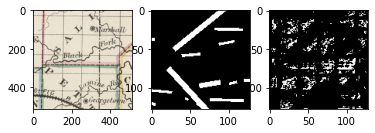

The learning rate for the optimizer was decreased from 0.0001 to 1e-05


ValueError: in user code:

    File "C:\Users\Gerasimos\AppData\Local\Temp\ipykernel_21140\2779294654.py", line 12, in train_step  *
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    File "C:\Users\Gerasimos\anaconda3\envs\deepenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 646, in apply_gradients  **
        self._create_all_weights(var_list)
    File "C:\Users\Gerasimos\anaconda3\envs\deepenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 858, in _create_all_weights
        _ = self.iterations
    File "C:\Users\Gerasimos\anaconda3\envs\deepenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 866, in __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    File "C:\Users\Gerasimos\anaconda3\envs\deepenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1033, in iterations
        self._iterations = self.add_weight(
    File "C:\Users\Gerasimos\anaconda3\envs\deepenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1233, in add_weight
        variable = self._add_variable_with_custom_getter(
    File "C:\Users\Gerasimos\anaconda3\envs\deepenv\lib\site-packages\keras\engine\base_layer_utils.py", line 126, in make_variable
        return tf.compat.v1.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [9]:
fit(maptd, train_ds, test_ds, sum_writer, total_steps=200, step_to_reduce_lr=150)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)

In [ ]:
print(f'{opt.learning_rate}')